# Testing the functions in torchgp.parameterizations.sqrtvar

In [1]:
%matplotlib notebook

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchgp.symbolic import *
from torchgp.transforms import *
from torchgp.reparameterization import *
from torchgp.test_tools import *
from torchgp.kernels import *
from torchgp.parameterizations.sqrtvar import *
from torchgp.factorizations.randomized import *
from torchgp.natural_gradient import *
from torchgp.natural_gradient.optimizer import PatchAdam
import math
import networkx as nx
from matplotlib.pyplot import *
from itertools import chain
torch.set_default_dtype(torch.float32)

## Example 1a:

1. Fully observed
2. Gaussian likelihood
3. MC evaluation of likelihood, aka reparameterization gradients
4. 1D signal

In [2]:
#generate the data
x, yc, y = make_fake_herfd_fully_observed(1000, 200, mean_snr=1.0)

<IPython.core.display.Javascript object>


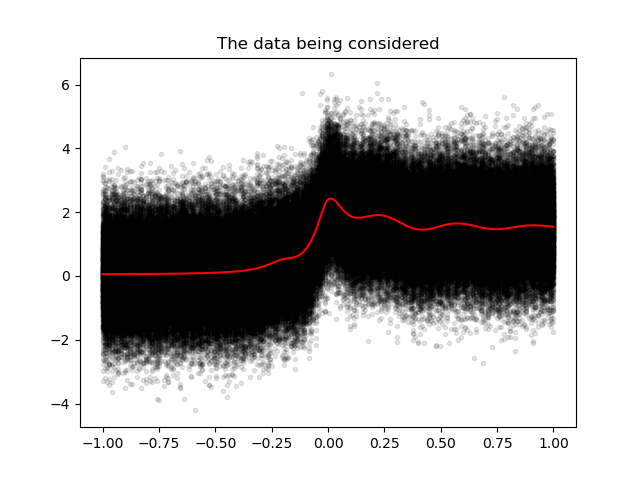

Text(0.5, 1.0, 'The data being considered')

In [3]:
figure()
plot(x,yc,'k.',alpha=0.1)
plot(x[:200],y,'r')
title('The data being considered')

In [6]:
class VFE_1D(torch.nn.Module):
    def __init__(self, U, Ntotal, Nmc = 10, std_lik_init = 5.0, lenscale_init = 0.2, dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        #define the input parameters
        #posterior mean vector
        m0 = MeanSymbol('m0')
        m = Vector('m')
        #posterior variance vector parameter
        L = Matrix('L')
        #axes that kernels are evaluated on
        u = Vector('u')
        f = Vector('f')
        #Kernels
        #these are the symbols that go into the graph
        K = Kernel('K')
        #observations, arranged Nx1
        y = Vector('y')
        Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        Nmc = Constant(Nmc)
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl(K, u, m0, L, m, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K, u, f, m0, m, jitter)
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = var_fullspace_diag(K, f) - var_subspace_diag(K, u, f, jitter) + var_posterior_diag(K, u, f, L, jitter)
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        
        ### Gaussian Likelihood in f-space ###
#         ve_loss = analytic_gaussian_likelihood(y, mf, varf, std_lik, Ntotal)
        ϵ = StdNormalSample(mf,Nmc)
        z = Sqrt(varf)*ϵ + mf
        ve_loss = gaussian_likelihood(y, z, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #symbolic functions needed for natural gradient:
        xi_to_source = sqrtvar_to_source(m,L)
        graph = expr2graph(Label(String("expr"), xi_to_source))
        self._xi_to_source = graph2ast(graph, compiled=True, debug=False)
        source_mean = Vector('source_mean')
        source_var = Matrix('source_var')
        source_to_xi = source_to_sqrtvar(source_mean, source_var, jitter)
        graph = expr2graph(Label(String("expr"), source_to_xi))
        self._source_to_xi = graph2ast(graph, compiled=True, debug=False)
        
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u': torch.nn.Parameter(torch.linspace(-1,1,U,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False)
            })

            #modules containing parameters go here:
            self.stored_modules = torch.nn.ModuleDict({
                'K': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]], dtype=self.dtype)),
                'm0': ConstantMean(torch.tensor(0., dtype=self.dtype), dtype=self.dtype),
                })
            #modules containing variational parameters go here:
            priorL = (self.stored_modules['K'](self.hyper_params['u'],self.hyper_params['u']) + 
                  torch.eye(U)*1e-4).cholesky()
            self.variational_gaussian = MVNGaussianSqrtVar(U, dtype=self.dtype)
            self.variational_gaussian.custom_L_init(priorL)
    def kl_loss(self):
        m, L = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'L': L,
            'm': m
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, x):
        m, L = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'f': x,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': L,
            'm': m
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, x):
        m, L = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'f': x,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': L,
            'm': m
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self, x):
        m, L = self.variational_gaussian.unpack()
        leaves = {
            'f': x,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': L,
            'm': m
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self, x):
        m, L = self.variational_gaussian.unpack()
        leaves = {
            'f': x,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'L': L,
            'm': m
        }
        result = self._var_pred(**leaves)
        return result.var_pred
    def xi_to_source(self, xi):
        m, L = self.variational_gaussian.unpack(xi_packed=xi)
        leaves = {
                'f': x,
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'L': L,
                'm': m
            }
        m,S = self._xi_to_source(**leaves).expr
        return [m,S]
    def source_to_xi(self, m, S):
        leaves = {
                'f': x,
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'source_mean': m,
                'source_var': S
            }
        xi_unpacked = self._source_to_xi(**leaves).expr
        xi = self.variational_gaussian.pack(xi_unpacked)
        if torch.is_tensor(xi):
            return [xi]
        else:
            return list(xi)
        

In [7]:
m = VFE_1D(30,200*1000);
# m.hyper_params['u'].requires_grad = False
# m.stored_modules['K']._lengthscale_storage.requires_grad = False
# m.stored_modules['K']._amplitude_storage.requires_grad = False
# m.stored_modules['m0'].value.requires_grad = False
# m.cuda()
hyper_optimizer = torch.optim.Adam(chain(m.hyper_params.parameters(), m.stored_modules.parameters()),lr=1e-2)
optimizer = NaturalGradient(m.variational_gaussian.parameters(), lr=1)
schedule = LogSpaceScheduler(optimizer, -5, -1.0, 25)
bigbatcher = BigBatchScheduler(1000,5000,10,30)


epochs = 300
# scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(torch.from_numpy(x.astype('float32')), torch.from_numpy(yc.astype('float32')))
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_modules.K._lengthscale_storage': m._makepos,
                          'stored_modules.K._amplitude_storage': m._makepos},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs):
    bsize = bigbatcher.step()
    print(bsize)
    d = DataLoader(dataset=data, shuffle=True, batch_size=int(bsize))
    for (xb,yb) in d:
#         xbc, ybc = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        hyper_optimizer.zero_grad()
        loss = m.loss(yb, xb)
        loss.backward()
        hyper_optimizer.step()
        schedule.step()
        optimizer.step(m.xi_to_source, m.source_to_xi)
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    print(Logger.report("epoch {:d}: ".format(i)))
        

Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/90aa7d00bb838b54.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/078818802d755c5c.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/f31ae3cd60b738d7.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/afa4975ac105a590.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/13883727abfad2d0.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/1b3667f617961643.py
Module path:  /Users/fdfuller/SLAC National Ac

KeyboardInterrupt: 

In [8]:
m.cpu()

VFE_1D(
  (hyper_params): ParameterDict(
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u): Parameter containing: [torch.FloatTensor of size 30x1]
  )
  (stored_modules): ModuleDict(
    (K): ARDRBFKernel(lengthscale=tensor([[0.0983]]), amplitude=0.31276655197143555)
    (m0): ConstantMean(value=1.0351722240447998)
  )
  (variational_gaussian): MVNGaussianSqrtVar(
    (packed_params): ModuleDict(
      (m): WrappedVector()
      (L): ConstrainedLowerTriangular()
    )
  )
)

In [9]:
figure()
μ = m.predict_mean(torch.linspace(-1,1,200).unsqueeze(1)).detach().numpy().squeeze()
σ = np.sqrt(m.predict_var(torch.linspace(-1,1,200).unsqueeze(1)).detach().numpy().squeeze())
plot(torch.linspace(-1,1,200).numpy(), μ, color='r',label='estimate')
fill_between(torch.linspace(-1,1,200).numpy(), μ + σ, μ - σ,color='k',alpha=0.5,label='+/- σ')
plot(x[:200],y,color='k',label='ground truth')
legend()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


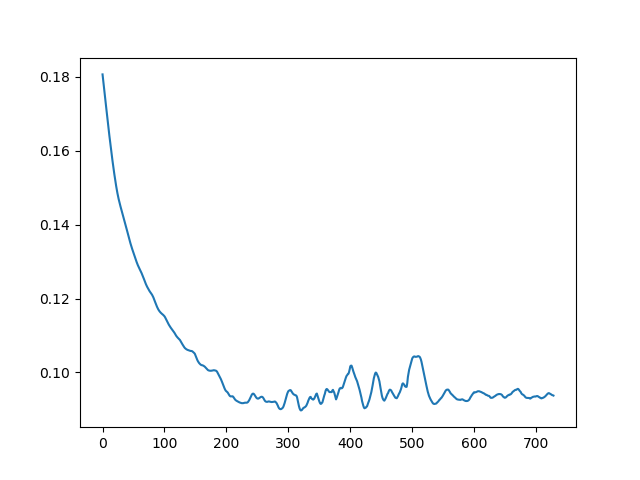

<IPython.core.display.Javascript object>


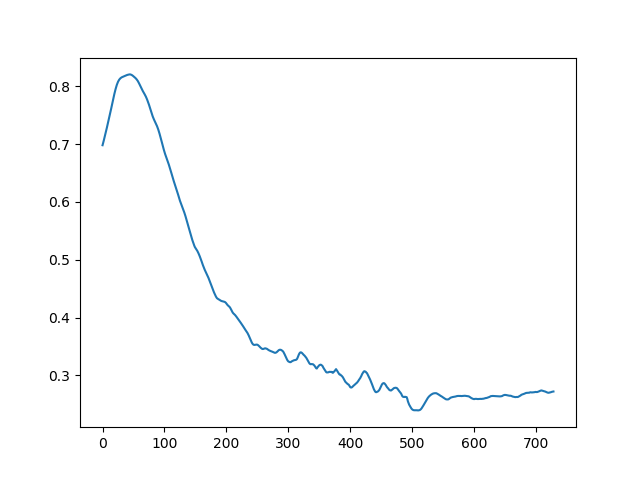

<IPython.core.display.Javascript object>


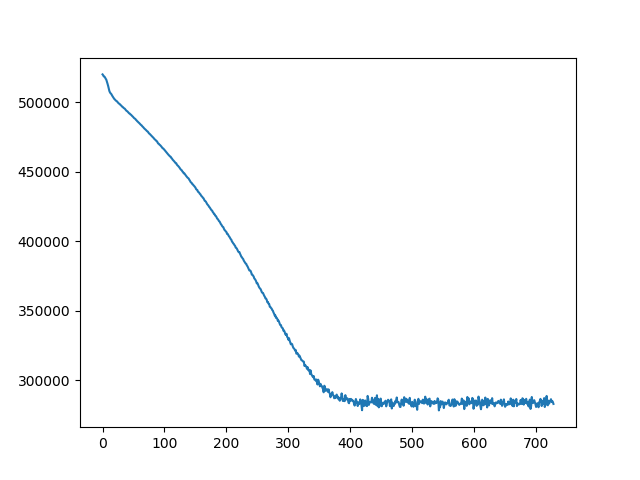

<IPython.core.display.Javascript object>


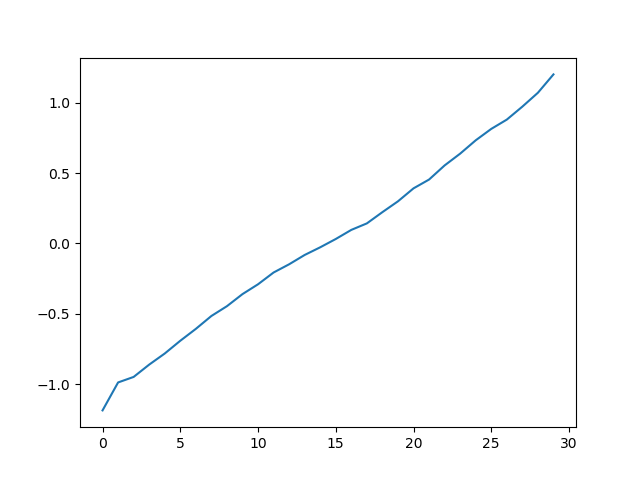

In [10]:
figure()
semilogy(Logger.val_dict['hyper_params.std_lik'])
figure()
plot(Logger.val_dict['stored_modules.K._lengthscale_storage'])
figure()
plot(Logger.val_dict['stored_modules.K._amplitude_storage'])
figure()
plot(Logger.val_dict['loss'])
figure()
plot(np.sort(m.hyper_params['u'].detach().numpy().squeeze()))

## Example 2a

1. 1D GPMM
2. Gaussian likelihood
3. MC evaluation of variational expectation, aka reparameterization gradients

<IPython.core.display.Javascript object>


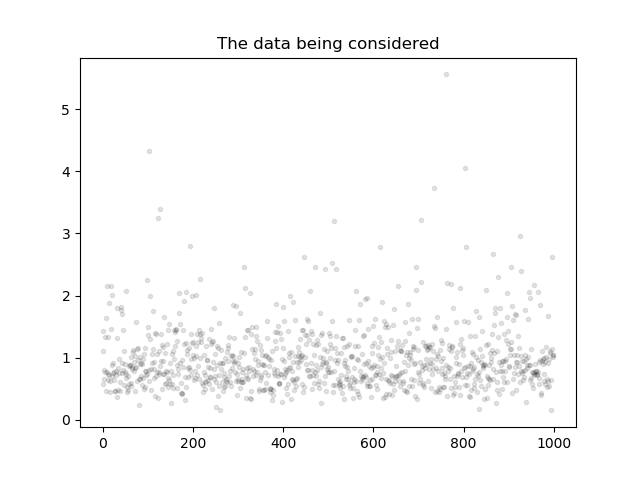

Text(0.5, 1.0, 'The data being considered')

In [6]:
#generate the data
nreps = 50000
pixels = 100
noise_type = 'Gaussian'
mean_snr = 10.0

X, yc, y = make_fake_herfd_weighted(nreps, pixels, noise_type=noise_type, mean_snr=mean_snr)
figure()
plot(yc[:1000],'k.',alpha=0.1)
title('The data being considered')

<IPython.core.display.Javascript object>


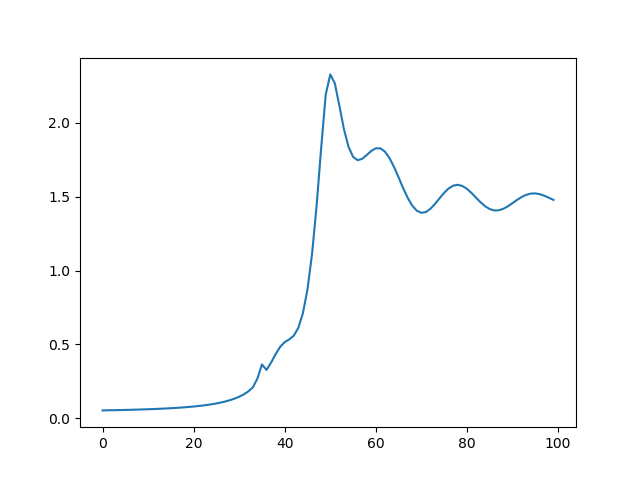

In [4]:
figure()
plot(y)

In [7]:
class VFE_1D_GPMM(torch.nn.Module):
    def __init__(self, U0, F0, Ntotal, Nmc=10, std_lik_init = 0.5, lenscale_init = 0.15,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        m = Vector('m')
        mprior = MeanSymbol('mprior')
        L0 = Matrix('L0')
        u0 = Vector('u0')
        f0 = Vector('f0')
        K0 = Kernel('K0')
        y = Vector('y')
        X = Matrix('X')
        Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        Nmc = Constant(Nmc)
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl(K0, u0, mprior, L0, m, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to weighted f-space ###
        mf = weighted_mean(K0, u0, f0, mprior, m, X, jitter)
        varf = weighted_var_fullspace_diag(K0, f0, X) - weighted_var_subspace_diag(K0, u0, f0, X, jitter) + \
                weighted_var_posterior_diag(K0, u0, f0, L0, X, jitter)
        
        ### Gaussian Likelihood in f-space ###
        ϵ = StdNormalSample(mf,Nmc)
        z = Sqrt(varf)*ϵ + mf
        ve_loss = gaussian_likelihood(y, z, std_lik, Ntotal)
#         ve_loss = analytic_gaussian_likelihood(y, mf, varf, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K0, u0, f0, mprior, m, jitter)
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = var_fullspace_diag(K0, f0) - var_subspace_diag(K0, u0, f0, jitter) + \
                var_posterior_diag(K0, u0, f0, L0, jitter)
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        #symbolic functions needed for natural gradient:
        xi_to_source = sqrtvar_to_source(m,L0)
        graph = expr2graph(Label(String("expr"), xi_to_source))
        self._xi_to_source = graph2ast(graph, compiled=True, debug=False)
        source_mean = Vector('source_mean')
        source_var = Matrix('source_var')
        source_to_xi = source_to_sqrtvar(source_mean, source_var, jitter)
        graph = expr2graph(Label(String("expr"), source_to_xi))
        self._source_to_xi = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u0': torch.nn.Parameter(torch.linspace(-1,1,U0,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f0': torch.nn.Parameter(torch.linspace(-1,1,F0,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_modules = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), amplitude=5.8),
                'mprior': ConstantMean(torch.tensor(3.))
                })
            #modules containing variational parameters go here:
            priorL = (self.stored_modules['K0'](self.hyper_params['u0'],self.hyper_params['u0']) + 
                  torch.eye(U0)*1e-4).cholesky()
            self.variational_gaussian = MVNGaussianSqrtVar(U0, dtype=self.dtype)
            self.variational_gaussian.custom_L_init(priorL)
    def kl_loss(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var_pred(**leaves)
        return result.var_pred
    def xi_to_source(self, xi):
        m, L0 = self.variational_gaussian.unpack(xi_packed=xi)
        leaves = {
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'L0': L0,
                'm': m
            }
        m,S = self._xi_to_source(**leaves).expr
        return [m,S]
    def source_to_xi(self, m, S):
        leaves = {
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'source_mean': m,
                'source_var': S
            }
        xi_unpacked = self._source_to_xi(**leaves).expr
        xi = self.variational_gaussian.pack(xi_unpacked)
        if torch.is_tensor(xi):
            return [xi]
        else:
            return list(xi)

In [10]:
FisherNormLimitedNaturalGradient?

In [11]:
m = VFE_1D_GPMM(80,100,50000);
# m.hyper_params['u0'].requires_grad = False
# m.stored_modules['K']._lengthscale_storage.requires_grad = False
# m.stored_modules['K']._amplitude_storage.requires_grad = False
# m.stored_modules['m0'].value.requires_grad = False
m.cuda()
hyper_optimizer = torch.optim.Adam(chain(m.hyper_params.parameters(), m.stored_modules.parameters()),lr=1e-3)
optimizer = FisherNormLimitedNaturalGradient(m.variational_gaussian.parameters(), lr=0.1, norm_limit=0.3)
bigbatcher = BigBatchScheduler(10000,50000,20,50)


epochs = 1000
# scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(torch.from_numpy(X.astype('float32')), torch.from_numpy(yc.astype('float32')))
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_modules.K0._lengthscale_storage': m._makepos,
                          'stored_modules.K0._amplitude_storage': m._makepos,
                          'stored_modules.mprior.value': lambda x: x},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})
c = 0        

In [13]:
while c < epochs:
    bsize = bigbatcher.step()
    print(bsize)
    d = DataLoader(dataset=data, shuffle=True, batch_size=int(bsize))
    for (xb,yb) in d:
        xbc, ybc = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        hyper_optimizer.zero_grad()
        loss = m.loss(ybc, xbc)
        loss.backward()
        hyper_optimizer.step()
#         schedule.step()
        lr = optimizer.step(m.xi_to_source, m.source_to_xi)
        Logger(extra_vals=[float(loss), float(lr)])
    print(Logger.report("epoch {:d}: ".format(c)))
    c += 1

10000
epoch 0: hyper_params.std_lik: 0.502157, stored_modules.K0._lengthscale_storage: 0.15038, stored_modules.K0._amplitude_storage: 5.79942, stored_modules.mprior.value: 2.99406, loss: 65405.2, step_size: 4.61431e-06, 
10000
epoch 1: hyper_params.std_lik: 0.503204, stored_modules.K0._lengthscale_storage: 0.150328, stored_modules.K0._amplitude_storage: 5.79933, stored_modules.mprior.value: 2.98922, loss: 23685, step_size: 3.68772e-05, 
10000
epoch 2: hyper_params.std_lik: 0.503669, stored_modules.K0._lengthscale_storage: 0.15022, stored_modules.K0._amplitude_storage: 5.7995, stored_modules.mprior.value: 2.98438, loss: 17027.8, step_size: 0.00014005, 
10000
epoch 3: hyper_params.std_lik: 0.503748, stored_modules.K0._lengthscale_storage: 0.150031, stored_modules.K0._amplitude_storage: 5.79934, stored_modules.mprior.value: 2.97952, loss: 14866.4, step_size: 0.000316615, 
10000
epoch 4: hyper_params.std_lik: 0.503562, stored_modules.K0._lengthscale_storage: 0.149761, stored_modules.K0._am

epoch 38: hyper_params.std_lik: 0.469084, stored_modules.K0._lengthscale_storage: 0.151526, stored_modules.K0._amplitude_storage: 5.79877, stored_modules.mprior.value: 2.81494, loss: 9325.88, step_size: 0.1, 
10000
epoch 39: hyper_params.std_lik: 0.467813, stored_modules.K0._lengthscale_storage: 0.151657, stored_modules.K0._amplitude_storage: 5.79819, stored_modules.mprior.value: 2.8103, loss: 9237.82, step_size: 0.1, 
10000
epoch 40: hyper_params.std_lik: 0.466536, stored_modules.K0._lengthscale_storage: 0.151784, stored_modules.K0._amplitude_storage: 5.79866, stored_modules.mprior.value: 2.80567, loss: 9069.17, step_size: 0.1, 
10000
epoch 41: hyper_params.std_lik: 0.465252, stored_modules.K0._lengthscale_storage: 0.151942, stored_modules.K0._amplitude_storage: 5.80009, stored_modules.mprior.value: 2.80105, loss: 8901.77, step_size: 0.1, 
10000
epoch 42: hyper_params.std_lik: 0.463962, stored_modules.K0._lengthscale_storage: 0.15207, stored_modules.K0._amplitude_storage: 5.80045, sto

epoch 76: hyper_params.std_lik: 0.41786, stored_modules.K0._lengthscale_storage: 0.150663, stored_modules.K0._amplitude_storage: 5.79753, stored_modules.mprior.value: 2.64077, loss: 3857.4, step_size: 0.0538018, 
12105
epoch 77: hyper_params.std_lik: 0.416473, stored_modules.K0._lengthscale_storage: 0.150513, stored_modules.K0._amplitude_storage: 5.79701, stored_modules.mprior.value: 2.63623, loss: 3674.16, step_size: 0.0557409, 
12105
epoch 78: hyper_params.std_lik: 0.415087, stored_modules.K0._lengthscale_storage: 0.150523, stored_modules.K0._amplitude_storage: 5.7967, stored_modules.mprior.value: 2.6317, loss: 3553.97, step_size: 0.0527394, 
12105
epoch 79: hyper_params.std_lik: 0.4137, stored_modules.K0._lengthscale_storage: 0.150514, stored_modules.K0._amplitude_storage: 5.79727, stored_modules.mprior.value: 2.62717, loss: 3345.64, step_size: 0.0516856, 
12105
epoch 80: hyper_params.std_lik: 0.412313, stored_modules.K0._lengthscale_storage: 0.150381, stored_modules.K0._amplitude_s

epoch 114: hyper_params.std_lik: 0.370011, stored_modules.K0._lengthscale_storage: 0.147011, stored_modules.K0._amplitude_storage: 5.78454, stored_modules.mprior.value: 2.48473, loss: -1822.27, step_size: 0.0917036, 
14210
epoch 115: hyper_params.std_lik: 0.368932, stored_modules.K0._lengthscale_storage: 0.146751, stored_modules.K0._amplitude_storage: 5.7846, stored_modules.mprior.value: 2.48119, loss: -1946.1, step_size: 0.0868264, 
14210
epoch 116: hyper_params.std_lik: 0.367854, stored_modules.K0._lengthscale_storage: 0.146504, stored_modules.K0._amplitude_storage: 5.78508, stored_modules.mprior.value: 2.47764, loss: -2074.03, step_size: 0.0964877, 
14210
epoch 117: hyper_params.std_lik: 0.366778, stored_modules.K0._lengthscale_storage: 0.146335, stored_modules.K0._amplitude_storage: 5.78488, stored_modules.mprior.value: 2.4741, loss: -2242.9, step_size: 0.0932696, 
14210
epoch 118: hyper_params.std_lik: 0.365703, stored_modules.K0._lengthscale_storage: 0.146125, stored_modules.K0._

epoch 152: hyper_params.std_lik: 0.330143, stored_modules.K0._lengthscale_storage: 0.139848, stored_modules.K0._amplitude_storage: 5.77806, stored_modules.mprior.value: 2.35066, loss: -7024.85, step_size: 0.0348864, 
16315
epoch 153: hyper_params.std_lik: 0.32913, stored_modules.K0._lengthscale_storage: 0.139773, stored_modules.K0._amplitude_storage: 5.77608, stored_modules.mprior.value: 2.34717, loss: -7266, step_size: 0.0327395, 
16315
epoch 154: hyper_params.std_lik: 0.328119, stored_modules.K0._lengthscale_storage: 0.139738, stored_modules.K0._amplitude_storage: 5.77404, stored_modules.mprior.value: 2.34369, loss: -7388.39, step_size: 0.0360825, 
16315
epoch 155: hyper_params.std_lik: 0.327109, stored_modules.K0._lengthscale_storage: 0.139724, stored_modules.K0._amplitude_storage: 5.77234, stored_modules.mprior.value: 2.34021, loss: -7457.84, step_size: 0.023708, 
16315
epoch 156: hyper_params.std_lik: 0.326102, stored_modules.K0._lengthscale_storage: 0.139681, stored_modules.K0._a

epoch 189: hyper_params.std_lik: 0.294085, stored_modules.K0._lengthscale_storage: 0.136386, stored_modules.K0._amplitude_storage: 5.74169, stored_modules.mprior.value: 2.22289, loss: -12282.8, step_size: 0.0272486, 
16315
epoch 190: hyper_params.std_lik: 0.293153, stored_modules.K0._lengthscale_storage: 0.136298, stored_modules.K0._amplitude_storage: 5.74169, stored_modules.mprior.value: 2.21949, loss: -12489, step_size: 0.0209027, 
16315
epoch 191: hyper_params.std_lik: 0.292224, stored_modules.K0._lengthscale_storage: 0.136322, stored_modules.K0._amplitude_storage: 5.74226, stored_modules.mprior.value: 2.2161, loss: -12760.2, step_size: 0.0261978, 
16315
epoch 192: hyper_params.std_lik: 0.291296, stored_modules.K0._lengthscale_storage: 0.136129, stored_modules.K0._amplitude_storage: 5.74235, stored_modules.mprior.value: 2.21271, loss: -12960.6, step_size: 0.0254543, 
16315
epoch 193: hyper_params.std_lik: 0.29037, stored_modules.K0._lengthscale_storage: 0.136054, stored_modules.K0._

epoch 227: hyper_params.std_lik: 0.266544, stored_modules.K0._lengthscale_storage: 0.134462, stored_modules.K0._amplitude_storage: 5.75781, stored_modules.mprior.value: 2.11991, loss: -16522.3, step_size: 0.0978653, 
18421
epoch 228: hyper_params.std_lik: 0.265901, stored_modules.K0._lengthscale_storage: 0.134359, stored_modules.K0._amplitude_storage: 5.75808, stored_modules.mprior.value: 2.11744, loss: -16593.8, step_size: 0.0846405, 
18421
epoch 229: hyper_params.std_lik: 0.26526, stored_modules.K0._lengthscale_storage: 0.134297, stored_modules.K0._amplitude_storage: 5.75939, stored_modules.mprior.value: 2.11498, loss: -16732.6, step_size: 0.0876827, 
18421
epoch 230: hyper_params.std_lik: 0.264621, stored_modules.K0._lengthscale_storage: 0.134259, stored_modules.K0._amplitude_storage: 5.75976, stored_modules.mprior.value: 2.11252, loss: -16847.4, step_size: 0.07403, 
18421
epoch 231: hyper_params.std_lik: 0.263983, stored_modules.K0._lengthscale_storage: 0.13413, stored_modules.K0._

epoch 264: hyper_params.std_lik: 0.243719, stored_modules.K0._lengthscale_storage: 0.133784, stored_modules.K0._amplitude_storage: 5.80213, stored_modules.mprior.value: 2.03075, loss: -20362.9, step_size: 0.0545004, 
20526
epoch 265: hyper_params.std_lik: 0.243129, stored_modules.K0._lengthscale_storage: 0.133614, stored_modules.K0._amplitude_storage: 5.80287, stored_modules.mprior.value: 2.0284, loss: -20499.2, step_size: 0.0528514, 
20526
epoch 266: hyper_params.std_lik: 0.242541, stored_modules.K0._lengthscale_storage: 0.133499, stored_modules.K0._amplitude_storage: 5.80412, stored_modules.mprior.value: 2.02605, loss: -20531.8, step_size: 0.0612527, 
20526
epoch 267: hyper_params.std_lik: 0.241954, stored_modules.K0._lengthscale_storage: 0.133286, stored_modules.K0._amplitude_storage: 5.80492, stored_modules.mprior.value: 2.02371, loss: -20636.8, step_size: 0.0615472, 
20526
epoch 268: hyper_params.std_lik: 0.241368, stored_modules.K0._lengthscale_storage: 0.133027, stored_modules.K

epoch 301: hyper_params.std_lik: 0.222853, stored_modules.K0._lengthscale_storage: 0.126443, stored_modules.K0._amplitude_storage: 5.77676, stored_modules.mprior.value: 1.94395, loss: -23931.1, step_size: 0.0462921, 
22631
epoch 302: hyper_params.std_lik: 0.222316, stored_modules.K0._lengthscale_storage: 0.126377, stored_modules.K0._amplitude_storage: 5.77707, stored_modules.mprior.value: 1.94161, loss: -24015.1, step_size: 0.0392726, 
22631
epoch 303: hyper_params.std_lik: 0.221781, stored_modules.K0._lengthscale_storage: 0.126411, stored_modules.K0._amplitude_storage: 5.77735, stored_modules.mprior.value: 1.93927, loss: -24215.8, step_size: 0.0524862, 
22631
epoch 304: hyper_params.std_lik: 0.221247, stored_modules.K0._lengthscale_storage: 0.126278, stored_modules.K0._amplitude_storage: 5.77651, stored_modules.mprior.value: 1.93693, loss: -24290.5, step_size: 0.053097, 
22631
epoch 305: hyper_params.std_lik: 0.220714, stored_modules.K0._lengthscale_storage: 0.126154, stored_modules.K

epoch 338: hyper_params.std_lik: 0.203942, stored_modules.K0._lengthscale_storage: 0.125171, stored_modules.K0._amplitude_storage: 5.76591, stored_modules.mprior.value: 1.85883, loss: -27501.8, step_size: 0.0362835, 
22631
epoch 339: hyper_params.std_lik: 0.203458, stored_modules.K0._lengthscale_storage: 0.12507, stored_modules.K0._amplitude_storage: 5.76556, stored_modules.mprior.value: 1.85659, loss: -27327.3, step_size: 0.0424496, 
22631
epoch 340: hyper_params.std_lik: 0.202975, stored_modules.K0._lengthscale_storage: 0.125035, stored_modules.K0._amplitude_storage: 5.76575, stored_modules.mprior.value: 1.85434, loss: -27629.8, step_size: 0.0468197, 
22631
epoch 341: hyper_params.std_lik: 0.202494, stored_modules.K0._lengthscale_storage: 0.125047, stored_modules.K0._amplitude_storage: 5.76629, stored_modules.mprior.value: 1.8521, loss: -27727.5, step_size: 0.0418946, 
22631
epoch 342: hyper_params.std_lik: 0.202014, stored_modules.K0._lengthscale_storage: 0.124994, stored_modules.K0

epoch 375: hyper_params.std_lik: 0.186963, stored_modules.K0._lengthscale_storage: 0.122167, stored_modules.K0._amplitude_storage: 5.75835, stored_modules.mprior.value: 1.77714, loss: -31116.4, step_size: 0.0114406, 
24736
epoch 376: hyper_params.std_lik: 0.186531, stored_modules.K0._lengthscale_storage: 0.122111, stored_modules.K0._amplitude_storage: 5.7583, stored_modules.mprior.value: 1.77498, loss: -30856.5, step_size: 0.0118973, 
24736
epoch 377: hyper_params.std_lik: 0.1861, stored_modules.K0._lengthscale_storage: 0.121999, stored_modules.K0._amplitude_storage: 5.75772, stored_modules.mprior.value: 1.77282, loss: -30507.5, step_size: 0.0122402, 
24736
epoch 378: hyper_params.std_lik: 0.18567, stored_modules.K0._lengthscale_storage: 0.121786, stored_modules.K0._amplitude_storage: 5.75631, stored_modules.mprior.value: 1.77068, loss: -30657.8, step_size: 0.0119283, 
24736
epoch 379: hyper_params.std_lik: 0.185242, stored_modules.K0._lengthscale_storage: 0.121477, stored_modules.K0._

epoch 412: hyper_params.std_lik: 0.173649, stored_modules.K0._lengthscale_storage: 0.120235, stored_modules.K0._amplitude_storage: 5.71963, stored_modules.mprior.value: 1.70816, loss: -33110.7, step_size: 0.0869785, 
26842
epoch 413: hyper_params.std_lik: 0.17339, stored_modules.K0._lengthscale_storage: 0.120179, stored_modules.K0._amplitude_storage: 5.7192, stored_modules.mprior.value: 1.70676, loss: -33200, step_size: 0.086164, 
26842
epoch 414: hyper_params.std_lik: 0.173131, stored_modules.K0._lengthscale_storage: 0.120135, stored_modules.K0._amplitude_storage: 5.7186, stored_modules.mprior.value: 1.70536, loss: -33350.6, step_size: 0.0837284, 
26842
epoch 415: hyper_params.std_lik: 0.172872, stored_modules.K0._lengthscale_storage: 0.120143, stored_modules.K0._amplitude_storage: 5.71813, stored_modules.mprior.value: 1.70396, loss: -33334.9, step_size: 0.0670277, 
26842
epoch 416: hyper_params.std_lik: 0.172615, stored_modules.K0._lengthscale_storage: 0.120173, stored_modules.K0._am

epoch 449: hyper_params.std_lik: 0.164439, stored_modules.K0._lengthscale_storage: 0.119374, stored_modules.K0._amplitude_storage: 5.70282, stored_modules.mprior.value: 1.65704, loss: -34904.6, step_size: 0.0618335, 
28947
epoch 450: hyper_params.std_lik: 0.164201, stored_modules.K0._lengthscale_storage: 0.119181, stored_modules.K0._amplitude_storage: 5.70126, stored_modules.mprior.value: 1.65568, loss: -35007.1, step_size: 0.0860147, 
28947
epoch 451: hyper_params.std_lik: 0.163963, stored_modules.K0._lengthscale_storage: 0.119091, stored_modules.K0._amplitude_storage: 5.69974, stored_modules.mprior.value: 1.65433, loss: -35000.8, step_size: 0.0813189, 
28947
epoch 452: hyper_params.std_lik: 0.163727, stored_modules.K0._lengthscale_storage: 0.118969, stored_modules.K0._amplitude_storage: 5.69831, stored_modules.mprior.value: 1.65298, loss: -35084.8, step_size: 0.0733724, 
28947
epoch 453: hyper_params.std_lik: 0.16349, stored_modules.K0._lengthscale_storage: 0.118888, stored_modules.K

epoch 486: hyper_params.std_lik: 0.156014, stored_modules.K0._lengthscale_storage: 0.118336, stored_modules.K0._amplitude_storage: 5.68657, stored_modules.mprior.value: 1.60753, loss: -36497.3, step_size: 0.0592961, 
28947
epoch 487: hyper_params.std_lik: 0.155797, stored_modules.K0._lengthscale_storage: 0.118234, stored_modules.K0._amplitude_storage: 5.68593, stored_modules.mprior.value: 1.60621, loss: -36593.9, step_size: 0.0664762, 
28947
epoch 488: hyper_params.std_lik: 0.155581, stored_modules.K0._lengthscale_storage: 0.118193, stored_modules.K0._amplitude_storage: 5.68579, stored_modules.mprior.value: 1.60489, loss: -36625.2, step_size: 0.0647268, 
28947
epoch 489: hyper_params.std_lik: 0.155365, stored_modules.K0._lengthscale_storage: 0.11811, stored_modules.K0._amplitude_storage: 5.68521, stored_modules.mprior.value: 1.60358, loss: -36786.9, step_size: 0.0680413, 
28947
epoch 490: hyper_params.std_lik: 0.155149, stored_modules.K0._lengthscale_storage: 0.118077, stored_modules.K

epoch 523: hyper_params.std_lik: 0.148351, stored_modules.K0._lengthscale_storage: 0.115794, stored_modules.K0._amplitude_storage: 5.66652, stored_modules.mprior.value: 1.55928, loss: -38020.3, step_size: 0.0479737, 
31052
epoch 524: hyper_params.std_lik: 0.148154, stored_modules.K0._lengthscale_storage: 0.115737, stored_modules.K0._amplitude_storage: 5.66533, stored_modules.mprior.value: 1.558, loss: -37915.7, step_size: 0.0520842, 
31052
epoch 525: hyper_params.std_lik: 0.147958, stored_modules.K0._lengthscale_storage: 0.115711, stored_modules.K0._amplitude_storage: 5.66434, stored_modules.mprior.value: 1.55672, loss: -38004.6, step_size: 0.0440284, 
31052
epoch 526: hyper_params.std_lik: 0.147762, stored_modules.K0._lengthscale_storage: 0.115646, stored_modules.K0._amplitude_storage: 5.66291, stored_modules.mprior.value: 1.55543, loss: -37957.5, step_size: 0.0467163, 
31052
epoch 527: hyper_params.std_lik: 0.147567, stored_modules.K0._lengthscale_storage: 0.115573, stored_modules.K0

epoch 560: hyper_params.std_lik: 0.141423, stored_modules.K0._lengthscale_storage: 0.112792, stored_modules.K0._amplitude_storage: 5.62397, stored_modules.mprior.value: 1.5122, loss: -39209.8, step_size: 0.047245, 
33157
epoch 561: hyper_params.std_lik: 0.141246, stored_modules.K0._lengthscale_storage: 0.112795, stored_modules.K0._amplitude_storage: 5.62306, stored_modules.mprior.value: 1.51095, loss: -39199.7, step_size: 0.0526594, 
33157
epoch 562: hyper_params.std_lik: 0.141069, stored_modules.K0._lengthscale_storage: 0.112807, stored_modules.K0._amplitude_storage: 5.62246, stored_modules.mprior.value: 1.50971, loss: -39319.1, step_size: 0.0472174, 
33157
epoch 563: hyper_params.std_lik: 0.140893, stored_modules.K0._lengthscale_storage: 0.112767, stored_modules.K0._amplitude_storage: 5.62172, stored_modules.mprior.value: 1.50846, loss: -39209.5, step_size: 0.0522025, 
33157
epoch 564: hyper_params.std_lik: 0.140717, stored_modules.K0._lengthscale_storage: 0.112744, stored_modules.K0

epoch 597: hyper_params.std_lik: 0.135204, stored_modules.K0._lengthscale_storage: 0.112062, stored_modules.K0._amplitude_storage: 5.59873, stored_modules.mprior.value: 1.46681, loss: -40113, step_size: 0.0424684, 
33157
epoch 598: hyper_params.std_lik: 0.135046, stored_modules.K0._lengthscale_storage: 0.111932, stored_modules.K0._amplitude_storage: 5.59746, stored_modules.mprior.value: 1.4656, loss: -40225.8, step_size: 0.0554219, 
35263
epoch 599: hyper_params.std_lik: 0.134888, stored_modules.K0._lengthscale_storage: 0.111927, stored_modules.K0._amplitude_storage: 5.59635, stored_modules.mprior.value: 1.46439, loss: -40051.4, step_size: 0.0384109, 
35263
epoch 600: hyper_params.std_lik: 0.13473, stored_modules.K0._lengthscale_storage: 0.111874, stored_modules.K0._amplitude_storage: 5.59471, stored_modules.mprior.value: 1.46319, loss: -40387.3, step_size: 0.0438551, 
35263
epoch 601: hyper_params.std_lik: 0.134574, stored_modules.K0._lengthscale_storage: 0.111724, stored_modules.K0._

epoch 634: hyper_params.std_lik: 0.129666, stored_modules.K0._lengthscale_storage: 0.111707, stored_modules.K0._amplitude_storage: 5.60048, stored_modules.mprior.value: 1.42321, loss: -41376, step_size: 0.0393042, 
35263
epoch 635: hyper_params.std_lik: 0.129525, stored_modules.K0._lengthscale_storage: 0.111746, stored_modules.K0._amplitude_storage: 5.6018, stored_modules.mprior.value: 1.42205, loss: -40980.9, step_size: 0.0422204, 
35263
epoch 636: hyper_params.std_lik: 0.129385, stored_modules.K0._lengthscale_storage: 0.111751, stored_modules.K0._amplitude_storage: 5.60264, stored_modules.mprior.value: 1.42089, loss: -41128.5, step_size: 0.0445305, 
35263
epoch 637: hyper_params.std_lik: 0.129245, stored_modules.K0._lengthscale_storage: 0.111685, stored_modules.K0._amplitude_storage: 5.60289, stored_modules.mprior.value: 1.41974, loss: -41177.7, step_size: 0.0513291, 
35263
epoch 638: hyper_params.std_lik: 0.129106, stored_modules.K0._lengthscale_storage: 0.111656, stored_modules.K0.

epoch 671: hyper_params.std_lik: 0.124768, stored_modules.K0._lengthscale_storage: 0.108728, stored_modules.K0._amplitude_storage: 5.58617, stored_modules.mprior.value: 1.38119, loss: -41941.1, step_size: 0.0376421, 
37368
epoch 672: hyper_params.std_lik: 0.124644, stored_modules.K0._lengthscale_storage: 0.108666, stored_modules.K0._amplitude_storage: 5.58541, stored_modules.mprior.value: 1.38008, loss: -41718.9, step_size: 0.0350276, 
37368
epoch 673: hyper_params.std_lik: 0.12452, stored_modules.K0._lengthscale_storage: 0.108587, stored_modules.K0._amplitude_storage: 5.58434, stored_modules.mprior.value: 1.37897, loss: -42138.2, step_size: 0.046197, 
37368
epoch 674: hyper_params.std_lik: 0.124397, stored_modules.K0._lengthscale_storage: 0.108502, stored_modules.K0._amplitude_storage: 5.58282, stored_modules.mprior.value: 1.37787, loss: -42098.3, step_size: 0.0301744, 
37368
epoch 675: hyper_params.std_lik: 0.124274, stored_modules.K0._lengthscale_storage: 0.108483, stored_modules.K0

epoch 708: hyper_params.std_lik: 0.12048, stored_modules.K0._lengthscale_storage: 0.109087, stored_modules.K0._amplitude_storage: 5.57006, stored_modules.mprior.value: 1.34052, loss: -42587.1, step_size: 0.0375189, 
39473
epoch 709: hyper_params.std_lik: 0.120372, stored_modules.K0._lengthscale_storage: 0.109025, stored_modules.K0._amplitude_storage: 5.56918, stored_modules.mprior.value: 1.33947, loss: -42657, step_size: 0.0301162, 
39473
epoch 710: hyper_params.std_lik: 0.120265, stored_modules.K0._lengthscale_storage: 0.108951, stored_modules.K0._amplitude_storage: 5.56836, stored_modules.mprior.value: 1.33841, loss: -42242.2, step_size: 0.0367308, 
39473
epoch 711: hyper_params.std_lik: 0.120158, stored_modules.K0._lengthscale_storage: 0.108927, stored_modules.K0._amplitude_storage: 5.56781, stored_modules.mprior.value: 1.33735, loss: -42448.4, step_size: 0.0316148, 
39473
epoch 712: hyper_params.std_lik: 0.120051, stored_modules.K0._lengthscale_storage: 0.108886, stored_modules.K0.

KeyboardInterrupt: 

In [14]:
m.cpu()

VFE_1D_GPMM(
  (hyper_params): ParameterDict(
      (f0): Parameter containing: [torch.FloatTensor of size 100x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u0): Parameter containing: [torch.FloatTensor of size 80x1]
  )
  (stored_modules): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.1086]]), amplitude=5.560652256011963)
    (mprior): ConstantMean(value=1.326848030090332)
  )
  (variational_gaussian): MVNGaussianSqrtVar(
    (packed_params): ModuleDict(
      (m): WrappedVector()
      (L): ConstrainedLowerTriangular()
    )
  )
)

<IPython.core.display.Javascript object>


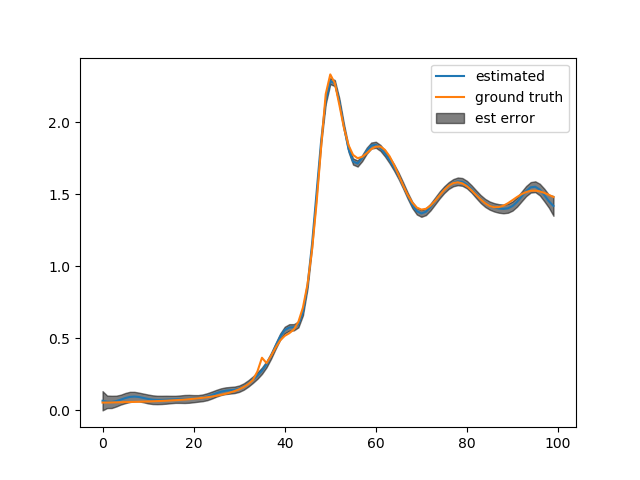

In [16]:
figure()
μ = m.predict_mean().detach().squeeze().numpy()
σ = m.predict_var().detach().sqrt().squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(100),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot(y,label='ground truth')
legend()

<IPython.core.display.Javascript object>


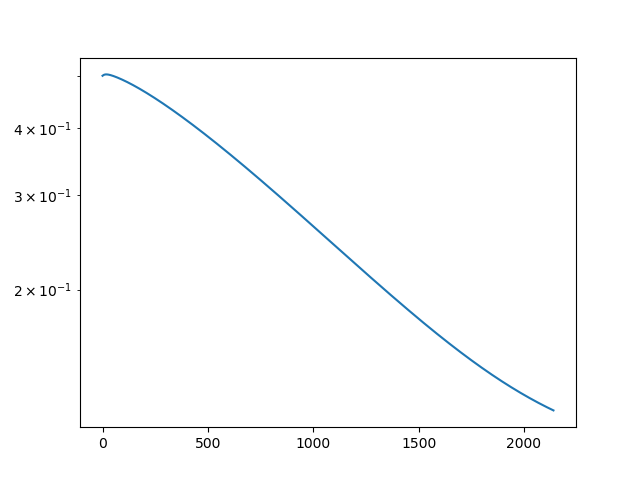

<IPython.core.display.Javascript object>


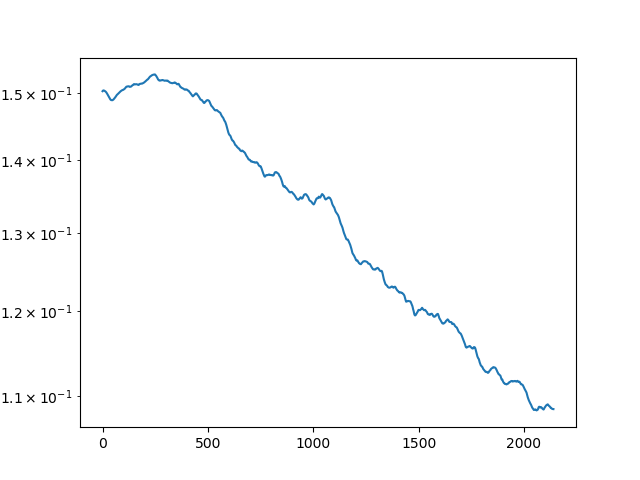

<IPython.core.display.Javascript object>


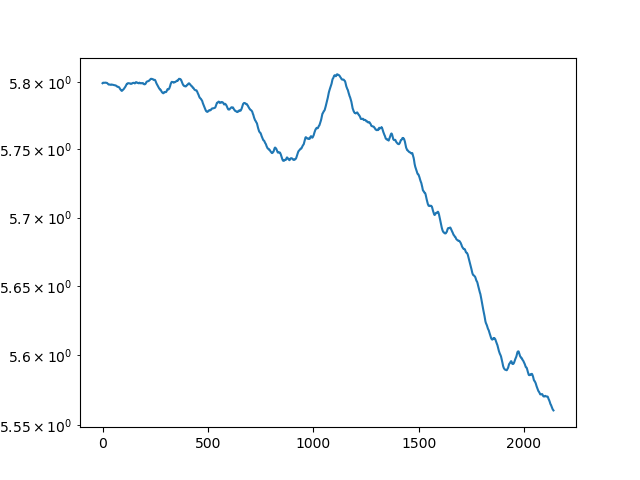

<IPython.core.display.Javascript object>


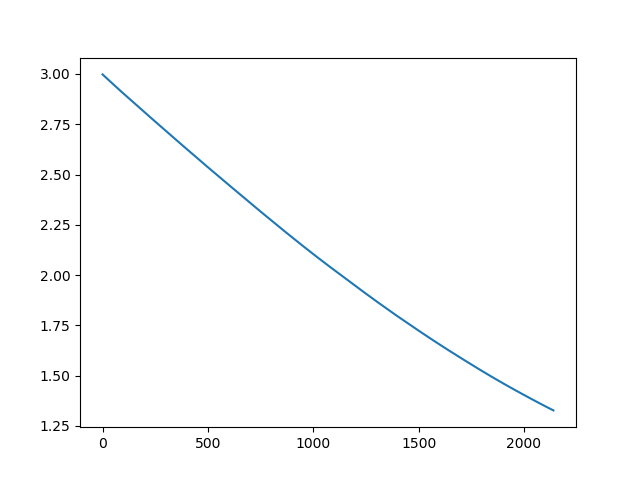

<IPython.core.display.Javascript object>


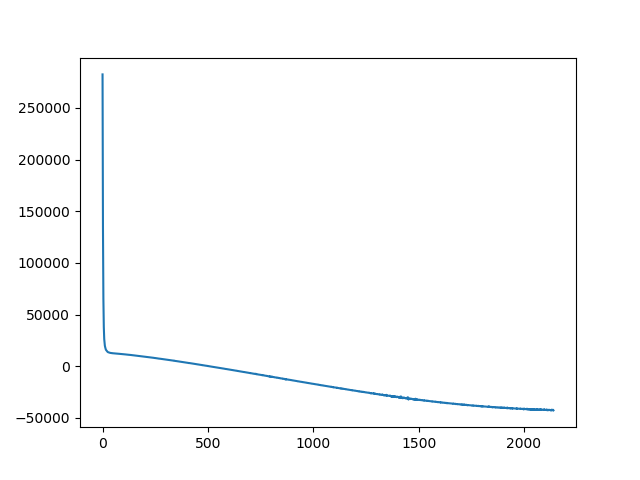

<IPython.core.display.Javascript object>


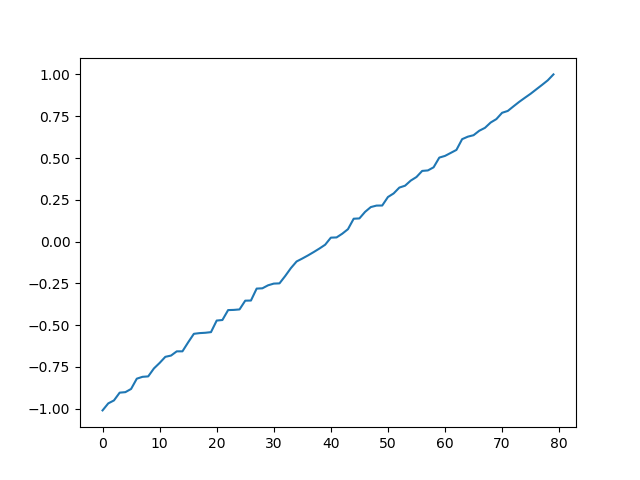

In [17]:
figure()
semilogy(Logger.val_dict['hyper_params.std_lik'])
figure()
semilogy(Logger.val_dict['stored_modules.K0._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_modules.K0._amplitude_storage'])
figure()
plot(Logger.val_dict['stored_modules.mprior.value'])
figure()
plot(Logger.val_dict['loss'])
figure()
plot(np.sort(m.hyper_params['u0'].detach().numpy().squeeze()))

## Example 3: GPMM with Poisson Noise & Poisson Likelihood

In [18]:
X,  yc, y = make_fake_herfd_weighted(50000, 100, noise_type='Poisson')

In [19]:
class VFE_1D_GPMM_Poisson(torch.nn.Module):
    def __init__(self, U0, F0, Ntotal, Nmc=10, max_root_rank = 100, std_lik_init = 0.5, lenscale_init = 0.15,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        m = Vector('m')
        mprior = MeanSymbol('mprior')
        L0 = Matrix('L0')
        u0 = Vector('u0')
        f0 = Vector('f0')
        K0 = Kernel('K0')
        y = Vector('y')
        X = Matrix('X')
        Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        Nmc = Constant(Nmc)
        max_root_rank = Constant(int(max_root_rank))
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl(K0, u0, mprior, L0, m, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K0, u0, f0, mprior, m, jitter)
#         mf = m
#         wmf = weighted_mean(K0, u0, f0, mprior, m, X, jitter)
#         r0 = CholeskyRoot(AddJitter(var_fullspace(K0, f0),jitter))
#         r1 = var_subspace_root(K0, u0, f0, jitter)
#         r2 = var_posterior_root(K0, u0, f0, L0, jitter)
        varf = var_fullspace(K0, f0) - var_subspace(K0, u0, f0, jitter) + \
                var_posterior(K0, u0, f0, L0, jitter)
        varf_factorize = RRUL(varf, max_root_rank, jitter)
        varf_U = Select(Constant(0), varf_factorize)
        varf_L = Select(Constant(1), varf_factorize)
#         varf_L = L0
#         varf_root = CholeskyRoot(AddJitter(varf,jitter))

#         w_varf = weighted_var_fullspace_diag(K0,f0, X) - \
#                 weighted_var_subspace_diag(K0, u0, f0, X, jitter) + \
#                 weighted_var_posterior_diag(K0, u0, f0, L0, X, jitter)
#         varf_diag = var_fullspace_diag(K0,f0) - \
#                 var_subspace_diag(K0, u0, f0, jitter) + \
#                 var_posterior_diag(K0, u0, f0, L0, jitter)
        
        ### Gaussian Likelihood in f-space ###
#         ϵ = StdNormalSample(varf_diag,Nmc)
        ϵ = StdNormalSampleVarSize(varf_L,Select(Constant(0),Shape(X)))
#         ϵ = StdNormalSample(varf_root,Nmc)
#         z = (varf_root @ ϵ) + mf
        z = (varf_U @ (varf_L @ ϵ)) + mf
#         z = (varf_L @ ϵ) + mf
#         z = (Sqrt(varf_diag) * ϵ) + mf
        wz = PartialSum(X * Transpose(Exp(z)), Constant(1))
#         ve_loss = gaussian_likelihood(y, wz, std_lik, Ntotal)
        ve_loss = poisson_likelihood(y, wz, Ntotal)
#         ve_loss = analytic_gaussian_likelihood(y, mf, varf, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K0, u0, f0, mprior, m, jitter)
#         mf
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = var_fullspace_diag(K0, f0) - var_subspace_diag(K0, u0, f0, jitter) + \
                var_posterior_diag(K0, u0, f0, L0, jitter)
#         varf = ExtractDiagonal(L0 @ Transpose(L0))
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        #symbolic functions needed for natural gradient:
        xi_to_source = sqrtvar_to_source(m,L0)
        graph = expr2graph(Label(String("expr"), xi_to_source))
        self._xi_to_source = graph2ast(graph, compiled=True, debug=False)
        source_mean = Vector('source_mean')
        source_var = Matrix('source_var')
        source_to_xi = source_to_sqrtvar(source_mean, source_var, jitter)
        graph = expr2graph(Label(String("expr"), source_to_xi))
        self._source_to_xi = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u0': torch.nn.Parameter(torch.linspace(-1,1,U0,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f0': torch.nn.Parameter(torch.linspace(-1,1,F0,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_modules = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), amplitude=5.8),
                'mprior': ConstantMean(torch.tensor(1.1), dtype=self.dtype)
                })
            #modules containing variational parameters go here:
            priorL = (self.stored_modules['K0'](self.hyper_params['u0'],self.hyper_params['u0']) + 
                  torch.eye(U0)*1e-4).cholesky()
            self.variational_gaussian = MVNGaussianSqrtVar(U0, dtype=self.dtype)
            self.variational_gaussian.custom_L_init(priorL)
    def kl_loss(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self):
        m, L0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'L0': L0,
            'm': m,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var_pred(**leaves)
        return result.var_pred
    def xi_to_source(self, xi):
        m, L0 = self.variational_gaussian.unpack(xi_packed=xi)
        leaves = {
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'L0': L0,
                'm': m
            }
        m,S = self._xi_to_source(**leaves).expr
        return [m,S]
    def source_to_xi(self, m, S):
        leaves = {
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'source_mean': m,
                'source_var': S
            }
        xi_unpacked = self._source_to_xi(**leaves).expr
        xi = self.variational_gaussian.pack(xi_unpacked)
        if torch.is_tensor(xi):
            return [xi]
        else:
            return list(xi)

In [20]:
m = VFE_1D_GPMM_Poisson(80,100,50000, Nmc=10, max_root_rank=85);
m.hyper_params['u0'].requires_grad = True
# m.stored_modules['K0']._lengthscale_storage.requires_grad = False
# m.stored_modules['K0']._amplitude_storage.requires_grad = False
# m.stored_modules['mprior'].value.requires_grad = False
m.cuda()
hyper_optimizer = PatchAdam(chain(m.hyper_params.parameters(), m.stored_modules.parameters()),lr=1e-3)
optimizer = FisherNormLimitedNaturalGradient(m.variational_gaussian.parameters(), lr=0.1, norm_limit=0.3)
# optimizer2 = torch.optim.Adam(m.variational_gaussian.parameters(), lr=1e-2)
# schedule = LogSpaceScheduler(optimizer, -7, -2, 20)
bigbatcher = BigBatchScheduler(10000,50000,40,50)

initial = 0
epochs = 2050
final = -50
# scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(torch.from_numpy(X.astype('float32')), torch.from_numpy(yc.astype('float32')))
Logger = ScalarLogger(m, {'stored_modules.K0._lengthscale_storage': m._makepos,
                          'stored_modules.K0._amplitude_storage': m._makepos,
                          'stored_modules.mprior.value': lambda x: x},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})
means = []
stds = []
c = 0

In [21]:
m.cuda()
while c < epochs:
    bsize = bigbatcher.step()
    print(bsize)
    d = DataLoader(dataset=data, shuffle=True, batch_size=bsize)
    for (xb,yb) in d:
        xbc, ybc = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        hyper_optimizer.zero_grad()
        loss = m.loss(ybc, xbc)
        loss.backward()
#         schedule.step()
        lr = optimizer.step(m.xi_to_source, m.source_to_xi)
        if c<=initial:
            hyper_optimizer.step(null_step=True)
        else:
            hyper_optimizer.step(null_step=False)
        Logger(extra_vals=[float(loss), float(lr)])
    print(Logger.report("epoch {:d}: ".format(c)))
    with torch.no_grad():
        means.append(m.predict_mean().detach().squeeze())
        stds.append(m.predict_var().detach().sqrt().squeeze())
    c += 1


10000
epoch 0: stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 5.8, stored_modules.mprior.value: 1.1, loss: 172914, step_size: 3.02723e-06, 
10000
epoch 1: stored_modules.K0._lengthscale_storage: 0.150266, stored_modules.K0._amplitude_storage: 5.79991, stored_modules.mprior.value: 1.09513, loss: 138257, step_size: 9.26698e-06, 
10000
epoch 2: stored_modules.K0._lengthscale_storage: 0.150206, stored_modules.K0._amplitude_storage: 5.80017, stored_modules.mprior.value: 1.09026, loss: 122347, step_size: 1.96111e-05, 
10000
epoch 3: stored_modules.K0._lengthscale_storage: 0.149801, stored_modules.K0._amplitude_storage: 5.80144, stored_modules.mprior.value: 1.08549, loss: 115881, step_size: 3.55273e-05, 
10000
epoch 4: stored_modules.K0._lengthscale_storage: 0.149431, stored_modules.K0._amplitude_storage: 5.80192, stored_modules.mprior.value: 1.0809, loss: 112125, step_size: 3.26719e-05, 
10000
epoch 5: stored_modules.K0._lengthscale_storage: 0.148987, sto

epoch 44: stored_modules.K0._lengthscale_storage: 0.139851, stored_modules.K0._amplitude_storage: 5.80619, stored_modules.mprior.value: 0.880928, loss: 95346.2, step_size: 0.000981402, 
10000
epoch 45: stored_modules.K0._lengthscale_storage: 0.139846, stored_modules.K0._amplitude_storage: 5.80528, stored_modules.mprior.value: 0.875968, loss: 95614.5, step_size: 0.00189449, 
10000
epoch 46: stored_modules.K0._lengthscale_storage: 0.139836, stored_modules.K0._amplitude_storage: 5.80433, stored_modules.mprior.value: 0.871039, loss: 95849.5, step_size: 0.00117382, 
10000
epoch 47: stored_modules.K0._lengthscale_storage: 0.139872, stored_modules.K0._amplitude_storage: 5.80451, stored_modules.mprior.value: 0.866147, loss: 95193.6, step_size: 0.00176072, 
10000
epoch 48: stored_modules.K0._lengthscale_storage: 0.139865, stored_modules.K0._amplitude_storage: 5.8057, stored_modules.mprior.value: 0.861293, loss: 95020.8, step_size: 0.000976851, 
10000
epoch 49: stored_modules.K0._lengthscale_sto

epoch 87: stored_modules.K0._lengthscale_storage: 0.1423, stored_modules.K0._amplitude_storage: 5.82736, stored_modules.mprior.value: 0.708966, loss: 94927.2, step_size: 0.00195298, 
11025
epoch 88: stored_modules.K0._lengthscale_storage: 0.142448, stored_modules.K0._amplitude_storage: 5.82711, stored_modules.mprior.value: 0.706166, loss: 94259.9, step_size: 0.00248895, 
11025
epoch 89: stored_modules.K0._lengthscale_storage: 0.142752, stored_modules.K0._amplitude_storage: 5.8268, stored_modules.mprior.value: 0.703406, loss: 94803.3, step_size: 0.00213381, 
11025
epoch 90: stored_modules.K0._lengthscale_storage: 0.143019, stored_modules.K0._amplitude_storage: 5.82671, stored_modules.mprior.value: 0.700674, loss: 94784.5, step_size: 0.00243612, 
11025
epoch 91: stored_modules.K0._lengthscale_storage: 0.143224, stored_modules.K0._amplitude_storage: 5.82661, stored_modules.mprior.value: 0.697972, loss: 95266.3, step_size: 0.00273217, 
11025
epoch 92: stored_modules.K0._lengthscale_storage

epoch 130: stored_modules.K0._lengthscale_storage: 0.146652, stored_modules.K0._amplitude_storage: 5.82747, stored_modules.mprior.value: 0.593628, loss: 94601.6, step_size: 0.00135948, 
12051
epoch 131: stored_modules.K0._lengthscale_storage: 0.146499, stored_modules.K0._amplitude_storage: 5.8264, stored_modules.mprior.value: 0.59112, loss: 95926.4, step_size: 0.00169561, 
12051
epoch 132: stored_modules.K0._lengthscale_storage: 0.146547, stored_modules.K0._amplitude_storage: 5.82559, stored_modules.mprior.value: 0.588631, loss: 94136.6, step_size: 0.00118087, 
12051
epoch 133: stored_modules.K0._lengthscale_storage: 0.146593, stored_modules.K0._amplitude_storage: 5.82499, stored_modules.mprior.value: 0.586173, loss: 95900.9, step_size: 0.00168784, 
12051
epoch 134: stored_modules.K0._lengthscale_storage: 0.146554, stored_modules.K0._amplitude_storage: 5.8246, stored_modules.mprior.value: 0.583771, loss: 96266.6, step_size: 0.00190614, 
12051
epoch 135: stored_modules.K0._lengthscale_s

epoch 173: stored_modules.K0._lengthscale_storage: 0.147543, stored_modules.K0._amplitude_storage: 5.82281, stored_modules.mprior.value: 0.510265, loss: 94851.3, step_size: 0.00292719, 
13076
epoch 174: stored_modules.K0._lengthscale_storage: 0.147515, stored_modules.K0._amplitude_storage: 5.82318, stored_modules.mprior.value: 0.508889, loss: 95439.7, step_size: 0.0057235, 
13076
epoch 175: stored_modules.K0._lengthscale_storage: 0.147533, stored_modules.K0._amplitude_storage: 5.82435, stored_modules.mprior.value: 0.507541, loss: 94678.6, step_size: 0.00438024, 
13076
epoch 176: stored_modules.K0._lengthscale_storage: 0.147506, stored_modules.K0._amplitude_storage: 5.82511, stored_modules.mprior.value: 0.506229, loss: 94870.8, step_size: 0.00524271, 
13076
epoch 177: stored_modules.K0._lengthscale_storage: 0.147356, stored_modules.K0._amplitude_storage: 5.82572, stored_modules.mprior.value: 0.504953, loss: 95592.7, step_size: 0.00545371, 
13076
epoch 178: stored_modules.K0._lengthscale

epoch 216: stored_modules.K0._lengthscale_storage: 0.149063, stored_modules.K0._amplitude_storage: 5.83199, stored_modules.mprior.value: 0.466324, loss: 94256.3, step_size: 0.00579746, 
14102
epoch 217: stored_modules.K0._lengthscale_storage: 0.149181, stored_modules.K0._amplitude_storage: 5.8335, stored_modules.mprior.value: 0.465487, loss: 95200.6, step_size: 0.00419696, 
14102
epoch 218: stored_modules.K0._lengthscale_storage: 0.149306, stored_modules.K0._amplitude_storage: 5.83452, stored_modules.mprior.value: 0.464643, loss: 94976.6, step_size: 0.00366913, 
14102
epoch 219: stored_modules.K0._lengthscale_storage: 0.149433, stored_modules.K0._amplitude_storage: 5.83591, stored_modules.mprior.value: 0.463793, loss: 95156.2, step_size: 0.00434467, 
14102
epoch 220: stored_modules.K0._lengthscale_storage: 0.149569, stored_modules.K0._amplitude_storage: 5.83692, stored_modules.mprior.value: 0.462947, loss: 95723.7, step_size: 0.00495216, 
14102
epoch 221: stored_modules.K0._lengthscale

epoch 259: stored_modules.K0._lengthscale_storage: 0.149508, stored_modules.K0._amplitude_storage: 5.81947, stored_modules.mprior.value: 0.43924, loss: 94860.4, step_size: 0.0038239, 
15128
epoch 260: stored_modules.K0._lengthscale_storage: 0.149689, stored_modules.K0._amplitude_storage: 5.81918, stored_modules.mprior.value: 0.438799, loss: 95153, step_size: 0.003551, 
15128
epoch 261: stored_modules.K0._lengthscale_storage: 0.14987, stored_modules.K0._amplitude_storage: 5.81865, stored_modules.mprior.value: 0.438346, loss: 94480.5, step_size: 0.00268165, 
15128
epoch 262: stored_modules.K0._lengthscale_storage: 0.150142, stored_modules.K0._amplitude_storage: 5.81851, stored_modules.mprior.value: 0.437893, loss: 94935.3, step_size: 0.00334427, 
15128
epoch 263: stored_modules.K0._lengthscale_storage: 0.150373, stored_modules.K0._amplitude_storage: 5.81855, stored_modules.mprior.value: 0.437443, loss: 94590.7, step_size: 0.00393641, 
15128
epoch 264: stored_modules.K0._lengthscale_stora

epoch 302: stored_modules.K0._lengthscale_storage: 0.153673, stored_modules.K0._amplitude_storage: 5.81224, stored_modules.mprior.value: 0.429977, loss: 95525.1, step_size: 0.00142518, 
16153


KeyboardInterrupt: 

In [22]:
torch.exp(torch.tensor(1.1))

tensor(3.0042)

In [23]:
m.cpu()

VFE_1D_GPMM_Poisson(
  (hyper_params): ParameterDict(
      (f0): Parameter containing: [torch.FloatTensor of size 100x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u0): Parameter containing: [torch.FloatTensor of size 80x1]
  )
  (stored_modules): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.1537]]), amplitude=5.812740802764893)
    (mprior): ConstantMean(value=0.4299902021884918)
  )
  (variational_gaussian): MVNGaussianSqrtVar(
    (packed_params): ModuleDict(
      (m): WrappedVector()
      (L): ConstrainedLowerTriangular()
    )
  )
)

In [24]:
L = m.variational_gaussian.unpack()[1].detach()

In [25]:
S2 = L @ L.t()
Svals = S2.svd().S
cond = Svals.max()/Svals.min()
print(cond)

tensor(34437.7812)


<IPython.core.display.Javascript object>


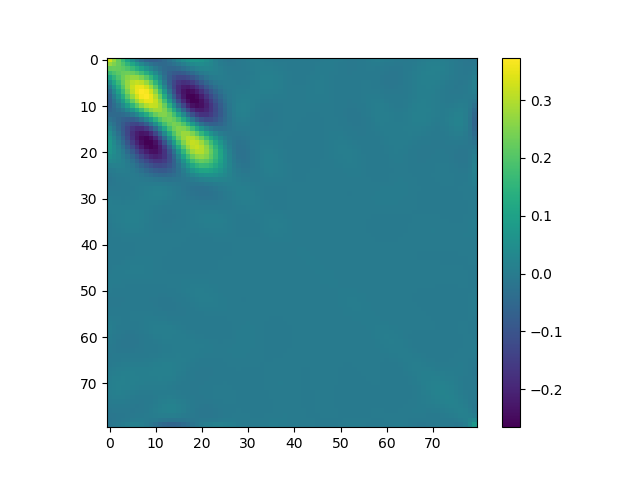

In [26]:
figure()
imshow(S2)
colorbar()

<IPython.core.display.Javascript object>


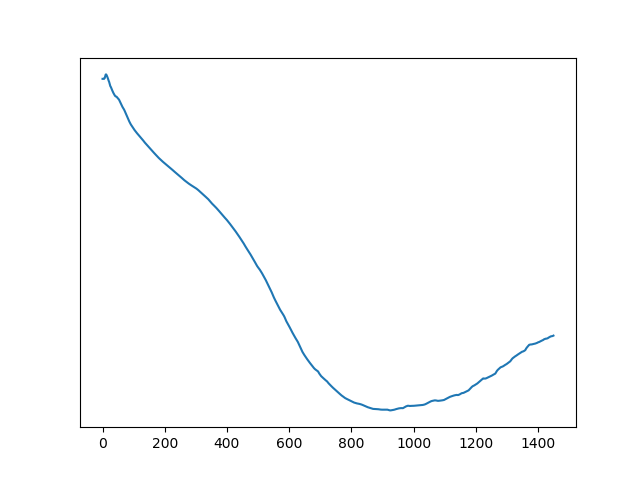

<IPython.core.display.Javascript object>


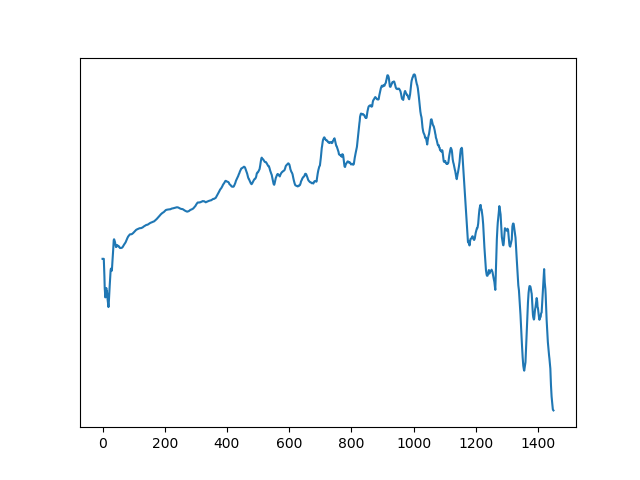

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [374]:
figure()
semilogy(Logger.val_dict['stored_modules.K0._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_modules.K0._amplitude_storage'])
figure()
plot(Logger.val_dict['stored_modules.mprior.value'])
figure()
semilogy(Logger.val_dict['loss'])

<IPython.core.display.Javascript object>


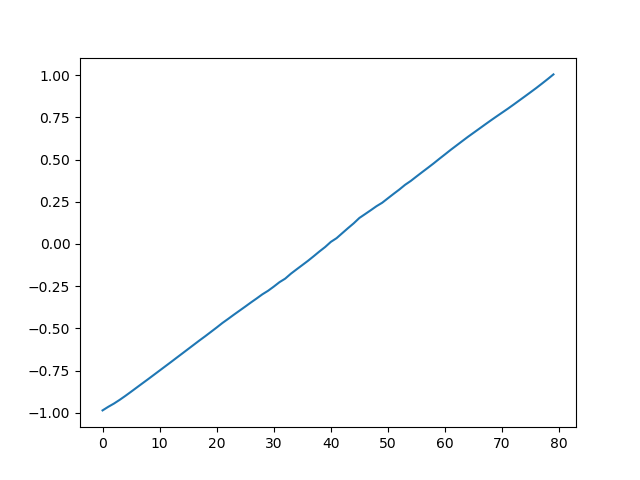

In [27]:
figure()
plot(np.sort(m.hyper_params['u0'].detach().numpy().squeeze()))

In [28]:
figure()
μ = m.predict_mean().detach().squeeze()
σ = m.predict_var().detach().sqrt().squeeze()
plot(torch.exp(μ).numpy(), label='estimated')
fill_between(np.arange(100),torch.exp(μ+σ).numpy(),torch.exp(μ-σ).numpy(),color='k',alpha=0.5,label='est error')
plot(y*np.sqrt(10),label='ground truth')
legend()
# savefig('100k-shots-nat-grad-HERFD.png')

<IPython.core.display.Javascript object>

In [377]:
ms = torch.cat([x.unsqueeze(1).cpu() for x in means],dim=1).numpy()
ss = torch.cat([x.unsqueeze(1).cpu() for x in stds],dim=1).numpy()

<IPython.core.display.Javascript object>


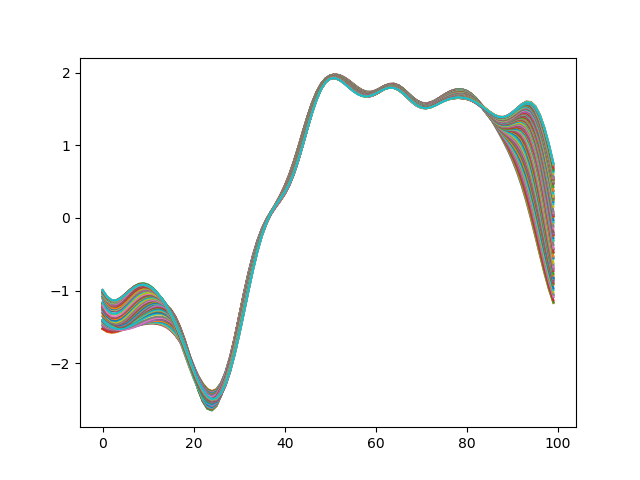

In [378]:
figure()
plot(ms[:,-100:])

In [358]:
figure()
vmin, vmax = np.percentile((ms).ravel(),[1,99])
imshow(ms,vmin=vmin, vmax=vmax,aspect=10.0)
colorbar()
# savefig('100k-poisson-HERFD-natgrad-mean-evolution.png')

<IPython.core.display.Javascript object>

In [202]:
np.diff?

In [288]:
figure()
vmin, vmax = np.percentile(ss.ravel(),[1,99])
imshow(ss,vmin=vmin, vmax=vmax, aspect=5.0)
colorbar()
# savefig('100k-poisson-HERFD-natgrad-std-evolution.png')

<IPython.core.display.Javascript object>

In [89]:
# m = VFE_1D_GPMM_Poisson(30,100,30000, Nmc=10);
# m.hyper_params['u'].requires_grad = False
# m.stored_modules['K0']._lengthscale_storage.requires_grad = False
# m.stored_modules['K0']._amplitude_storage.requires_grad = False
# m.stored_modules['mprior'].value.requires_grad = False
# m.cuda()
# hyper_optimizer = torch.optim.Adam(chain(m.hyper_params.parameters(), m.stored_modules.parameters()),lr=1e-2)
# optimizer = NaturalGradient(m.variational_gaussian.parameters(), lr=1)
# optimizer2 = torch.optim.Adam(m.variational_gaussian.parameters(), lr=1e-2)
# schedule = LogSpaceScheduler(optimizer, -5, -2, 100)
# bigbatcher = BigBatchScheduler(100000,100000,10,5)


epochs = 300
# scheduler = StepLR(optimizer,50,gamma=0.95)

# data = TensorDataset(torch.from_numpy(X.astype('float32')), torch.from_numpy(yc.astype('float32')))
# Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
#                           'stored_modules.K0._lengthscale_storage': m._makepos,
#                           'stored_modules.K0._amplitude_storage': m._makepos,
#                           'stored_modules.mprior.value': lambda x: x},
#                      extra_keys={'loss': lambda x: x,
#                                 'step_size': lambda x: x})

for i in range(epochs):
#     bsize = bigbatcher.step()
#     print(bsize)
    d = DataLoader(dataset=data, shuffle=True, batch_size=30000)
    for (xb,yb) in d:
#         xbc, ybc = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
#         optimizer2.zero_grad()
        hyper_optimizer.zero_grad()
        loss = m.loss(yb, xb)
        loss.backward()
        hyper_optimizer.step()
        schedule.step()
        optimizer.step(m.xi_to_source, m.source_to_xi)
#         optimizer2.step()
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    print(Logger.report("epoch {:d}: ".format(i)))
        

epoch 0: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0481469, stored_modules.K0._amplitude_storage: 1.46642, stored_modules.mprior.value: 2.25916, loss: 63629, step_size: 1e-05, 
epoch 1: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0482217, stored_modules.K0._amplitude_storage: 1.46743, stored_modules.mprior.value: 2.27202, loss: 60652.8, step_size: 1.07227e-05, 
epoch 2: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0482909, stored_modules.K0._amplitude_storage: 1.46851, stored_modules.mprior.value: 2.28452, loss: 63098.1, step_size: 1.14976e-05, 
epoch 3: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.048348, stored_modules.K0._amplitude_storage: 1.46971, stored_modules.mprior.value: 2.297, loss: 65120.2, step_size: 1.23285e-05, 
epoch 4: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0483502, stored_modules.K0._amplitude_storage: 1.47081, stored_modules.mprior.value: 

epoch 39: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0475938, stored_modules.K0._amplitude_storage: 1.49227, stored_modules.mprior.value: 2.55199, loss: 58724.3, step_size: 0.000151991, 
epoch 40: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0476179, stored_modules.K0._amplitude_storage: 1.49301, stored_modules.mprior.value: 2.55751, loss: 58875.5, step_size: 0.000162975, 
epoch 41: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0476486, stored_modules.K0._amplitude_storage: 1.49375, stored_modules.mprior.value: 2.5627, loss: 59152.4, step_size: 0.000174753, 
epoch 42: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0476453, stored_modules.K0._amplitude_storage: 1.49453, stored_modules.mprior.value: 2.56721, loss: 60187.4, step_size: 0.000187382, 
epoch 43: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0476242, stored_modules.K0._amplitude_storage: 1.49533, stored_modules

epoch 78: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0471934, stored_modules.K0._amplitude_storage: 1.51021, stored_modules.mprior.value: 2.65882, loss: 57578.6, step_size: 0.00231013, 
epoch 79: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0471971, stored_modules.K0._amplitude_storage: 1.51011, stored_modules.mprior.value: 2.65999, loss: 57828.2, step_size: 0.00247708, 
epoch 80: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0472, stored_modules.K0._amplitude_storage: 1.50996, stored_modules.mprior.value: 2.6611, loss: 57803.4, step_size: 0.00265609, 
epoch 81: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0472019, stored_modules.K0._amplitude_storage: 1.50986, stored_modules.mprior.value: 2.66196, loss: 57760.5, step_size: 0.00284804, 
epoch 82: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0472044, stored_modules.K0._amplitude_storage: 1.50973, stored_modules.mprior

RuntimeError: cholesky_cpu: U(4,4) is zero, singular U.